In [ ]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

setting tensorflow version in colab
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.15.0'

In [ ]:
# Cargamos los datos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1/1 [==============================] - 0s 321ms/step
   Model  Look_Back       MAE       MSE      RMSE        R2
0    CNN          1  0.017786  0.103546  0.017786  0.643550
1    RNN          1  0.019965  0.118665  0.019965  0.599878
2   LSTM          1  0.011503  0.074171  0.011503  0.769477
3    GRU          1  0.014708  0.087075  0.014708  0.705234
4    CNN          2  0.012303  0.098005  0.012303  0.787529
5    RNN          2  0.017039  0.105804  0.017039  0.705735
6   LSTM          2  0.015065  0.088884  0.015065  0.739822
7    GRU          2  0.010158  0.082344  0.010158  0.824571
8    CNN          3  0.021473  0.114742  0.021473  0.625051
9    RNN          3  0.041411  0.172543  0.041411  0.276914
10  LSTM          3  0.022314  0.116930  0.022314  0.610372
11   GRU          3  0.021892  0.110468  0.021892  0.617743
12   CNN          4  0.020334  0.113301  0.020334  0.537315
13   RNN          4  0.018653  0.109529  0.018653  0.575572
14  LSTM          4  0.016091  0.102045  0.0160

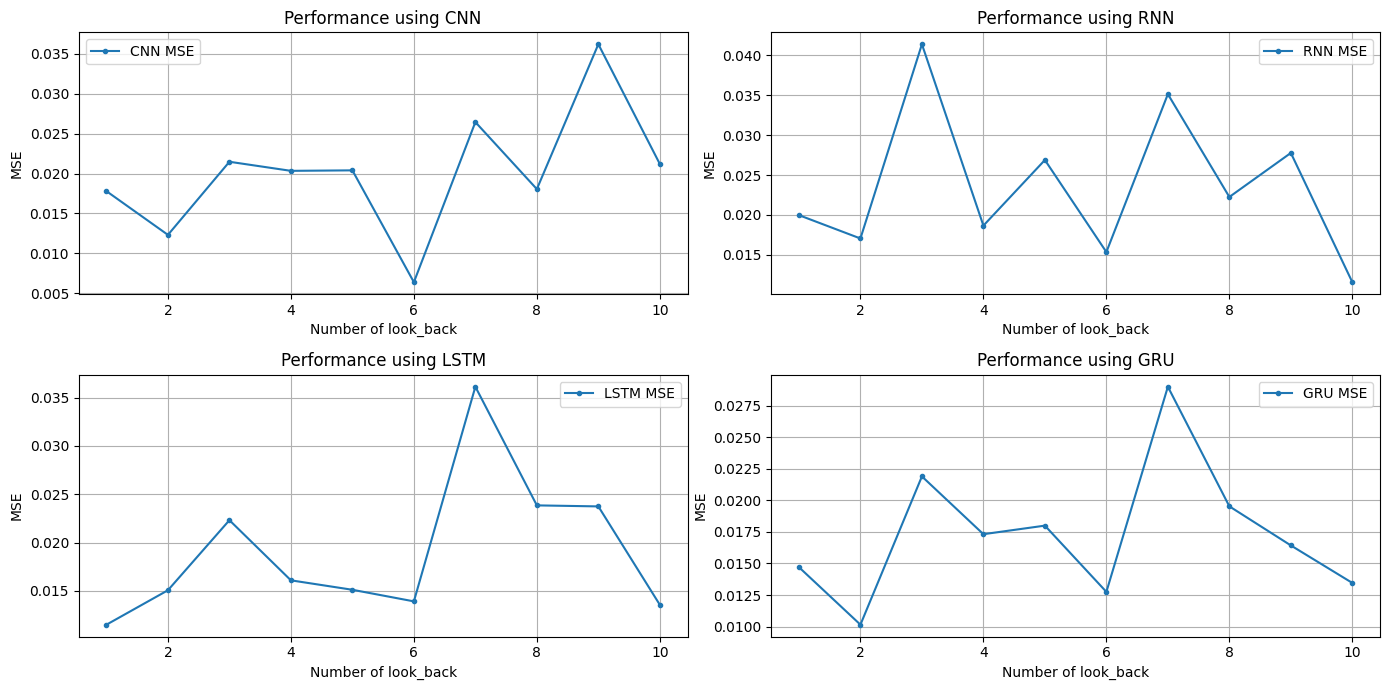

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, SimpleRNN, LSTM, GRU

# Cargar y normalizar los datos
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Monografía/datos_arbei/data_normalize.csv')
data[['ndvi', 'precipitation', 'real_evapotranspiration', 'interception', 'potential_evapotranspiration', 'soil_moisture', 'recharge']] = MinMaxScaler().fit_transform(
    data[['ndvi', 'precipitation', 'real_evapotranspiration', 'interception', 'potential_evapotranspiration', 'soil_moisture', 'recharge']]
)

# Convertir el DataFrame a un array de numpy, ignorando la columna de fecha
data_values = data[['ndvi', 'precipitation', 'real_evapotranspiration', 'interception', 'potential_evapotranspiration', 'soil_moisture', 'recharge']].values

# Función para crear secuencias
def create_sequences(data, n_past_steps=1, n_forecast_steps=1, n_overlay_steps=1, include_target_as_feature=False):
    x_sequence = []
    y_sequence = []
    start_idx = 0

    while True:
        end_idx = start_idx + n_past_steps
        forecast_end_idx = end_idx + n_forecast_steps

        if forecast_end_idx > len(data):
            break

        if include_target_as_feature:
            x = data[start_idx:end_idx]  # Usar todas las columnas excepto la de fecha
        else:
            x = data[start_idx:end_idx, 1:]  # Ignorar la columna de fecha y la columna objetivo
        y = data[end_idx:forecast_end_idx, 0]  # La columna objetivo es 'ndvi'
        x_sequence.append(x)
        y_sequence.append(y)

        start_idx += n_overlay_steps

    return np.array(x_sequence), np.array(y_sequence)

# Función para crear y entrenar modelos
def create_and_train_model(model_type, input_shape, x_train, y_train):
    model = Sequential()
    if model_type == "CNN":
        model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
        model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
        model.add(MaxPooling1D(pool_size=1))
        model.add(Dropout(0.3))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.3))
    elif model_type == "RNN":
        model.add(SimpleRNN(50, activation='relu', return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.3))
        model.add(SimpleRNN(50, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.3))
    elif model_type == "LSTM":
        model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape))
        model.add(LSTM(50, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.3))
    elif model_type == "GRU":
        model.add(GRU(50, activation='relu', return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.3))
        model.add(GRU(50, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.3))

    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse', 'RootMeanSquaredError'])
    model.fit(x_train, y_train, epochs=300, batch_size=32, validation_split=0.2, verbose=0)
    return model

# Evaluar los modelos
evaluation_results = []
look_back_values = np.array([1, 2, 3, 4, 5,6,7,8,9,10])
model_types = ["CNN", "RNN", "LSTM", "GRU"]

mse_results = {model_type: [] for model_type in model_types}

for look_back in look_back_values:
    # Crear las secuencias
    x, y = create_sequences(data_values, n_past_steps=look_back, n_forecast_steps=1, n_overlay_steps=1)

    # Dividir los datos en entrenamiento y prueba
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Asegurar que las dimensiones son correctas
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2]))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2]))

    for model_type in model_types:
        model = create_and_train_model(model_type, (x_train.shape[1], x_train.shape[2]), x_train, y_train)
        results = model.evaluate(x_test, y_test, verbose=0)
        y_pred = model.predict(x_test).flatten()
        ss_res = np.sum((y_test.flatten() - y_pred) ** 2)
        ss_tot = np.sum((y_test.flatten() - np.mean(y_test.flatten())) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        evaluation_results.append([model_type, look_back] + results[:3] + [r2])
        mse_results[model_type].append(results[2])  # Guardar MSE

# Crear un DataFrame con los resultados
results_df = pd.DataFrame(evaluation_results, columns=["Model", "Look_Back", "MAE", "MSE", "RMSE", "R2"])

print(results_df)

# Graficar el MSE para cada modelo en función del look_back
plt.figure(figsize=(14, 7))

for i, model_type in enumerate(model_types):
    plt.subplot(2, 2, i+1)
    plt.plot(look_back_values, mse_results[model_type], '.-', label=f'{model_type} MSE')
    plt.xlabel('Number of look_back')
    plt.ylabel('MSE')
    plt.title(f'Performance using {model_type}')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()



In [ ]:
# Elegir el mejor modelo basado en el MSE más bajo
best_model_info = results_df.loc[results_df['MSE'].idxmin()]
best_model_type = best_model_info['Model']
best_look_back = best_model_info['Look_Back']

print(f"Best model type: {best_model_type} with look_back: {best_look_back}")

Best model type: CNN with look_back: 6


In [ ]:
# Entrenar el mejor modelo nuevamente con todos los datos de entrenamiento
x, y = create_sequences(data_values, n_past_steps=best_look_back, n_forecast_steps=1, n_overlay_steps=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2]))

best_model, best_history = create_and_train_model(best_model_type, (x_train.shape[1], x_train.shape[2]), x_train, y_train)

TypeError: cannot unpack non-iterable Sequential object

In [ ]:
# Graficar la función de pérdida
plt.figure(figsize=(10, 5))
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Graficar los valores reales vs. los pronosticados por el modelo
y_pred_best = best_model.predict(x_test).flatten()
plt.figure(figsize=(10, 5))
plt.plot(y_test.flatten(), label='Real Values')
plt.plot(y_pred_best, label='Predicted Values')
plt.xlabel('Samples')
plt.ylabel('NDVI')
plt.title('Real vs Predicted NDVI')
plt.legend()
plt.grid()
plt.show()